## Prepare Masked Data

Here we are going to take our AI ready dataset and create a duplicate where the a previously generated outline of the fan is used to mask the image.

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import richdem as rd
import dask.array as da
from shapely.geometry import Polygon
from pyproj import CRS, Transformer

data_path = "/Users/GLaDOS/Documents/GitHub/MarsFans_OLD_CLONES/MLGEO2024_MarsFans/data_lvl2_cleaned-clipped/" # This is an example, change it to your own path

Note: you may need to restart the kernel to use updated packages.Collecting richdem
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for richdem
Failed to build richdem



  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
      Using RichDEM hash=Unknown, time=Unknown
      c:\Users\GLaDOS\anaconda3\envs\mars_env\Lib\site-packages\setuptools\dist.py:452: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
  

ModuleNotFoundError: No module named 'richdem'

In [2]:
def reproject_polygon(polygon, source_crs, target_crs):
    # Function to reproject a polygon from one CRS to another

    transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
    reprojected_coords = [transformer.transform(x, y) for x, y in polygon.exterior.coords]
    reprojected_polygon = Polygon(reprojected_coords)
    return reprojected_polygon

In [16]:
def quick_plot(data, title=None):
    # Function that quickly plots and image and value histogram

    # Remove NaN values for the histogram
    data_values = data.values.flatten()
    data_values = data_values[~np.isnan(data_values)]
    data_values = data_values[~np.isinf(data_values)]

    # Create the histogram
    n, bins = np.histogram(data_values, bins=50)

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the histogram
    ax[1].stairs(n, bins)
    ax[1].set_title(f"{title} Histogram")
    ax[1].set_xlabel("Value")
    ax[1].set_ylabel("Frequency")

    # Plot the reprojected DEM image
    data.plot(ax=ax[0], cmap = 'gray')
    ax[0].set_title(title)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [14]:
def clip_image(fan_mask, target, gdf_eb, name="None"):
    # Reproject the box mask to the same CRS as the imagery
    source_crs = gdf_eb.crs
    target_crs = target.rio.crs
    reprojected_mask = reproject_polygon(fan_mask, source_crs, target_crs)
    gdf_eb['geometry'].loc[0] = reprojected_mask

    # Extract the bounding latitude and longitude
    min_lon, min_lat, max_lon, max_lat = fan_mask.bounds

    print(f"Old Mask Bounding Box Coordinates:")
    print(f"Min Longitude: {min_lon}")
    print(f"Min Latitude: {min_lat}")
    print(f"Max Longitude: {max_lon}")
    print(f"Max Latitude: {max_lat}\n")

    # Extract the bounding latitude and longitude
    min_lon, min_lat, max_lon, max_lat = reprojected_mask.bounds

    print(f"New Mask Bounding Box Coordinates:")
    print(f"Min Longitude: {min_lon}")
    print(f"Min Latitude: {min_lat}")
    print(f"Max Longitude: {max_lon}")
    print(f"Max Latitude: {max_lat}\n")

    # Extract the bounding latitude and longitude
    min_lon, min_lat, max_lon, max_lat = target.rio.bounds()

    print(f"Image Bounding Box Coordinates:")
    print(f"Min Longitude: {min_lon}")
    print(f"Min Latitude: {min_lat}")
    print(f"Max Longitude: {max_lon}")
    print(f"Max Latitude: {max_lat}\n")

    # Plot the raster image
    fig, ax = plt.subplots(figsize=(6, 6))
    target.plot(ax=ax, cmap='gray')

    # Overlay the fan_mask
    gdf_eb.plot(ax=ax, facecolor='none', edgecolor='red',linewidth=4)

    plt.title('Image with Fan Mask Overlay')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    target_clipped = target.rio.clip([reprojected_mask], target_crs,drop=False)
    target_clipped = target_clipped.where((target_clipped >= 0) & (target_clipped <= 1), 0)

    quick_plot(target_clipped, name)

    return target_clipped

In [5]:
blendDEM = rxr.open_rasterio(data_path + "blendDEM_aiready.tif", cache=False)
blendSLOPE = rxr.open_rasterio(data_path + "blendSLOPE_aiready.tif", cache=False)

ctxDEM = rxr.open_rasterio(data_path + "ctxDEM_aiready.tif", cache=False)
ctxIMG = rxr.open_rasterio(data_path + "ctxIMG_aiready.tif", cache=False)
ctxSLOPE = rxr.open_rasterio(data_path + "ctxSLOPE_aiready.tif", cache=False)

dayIR = rxr.open_rasterio(data_path + "dayIR_aiready.tif", cache=False)
nightIR = rxr.open_rasterio(data_path + "nightIR_aiready.tif", cache=False)

hrscND = rxr.open_rasterio(data_path + "hrscND_aiready.tif", cache=False)
hrscP1 = rxr.open_rasterio(data_path + "hrscP1_aiready.tif", cache=False)
hrscP2 = rxr.open_rasterio(data_path + "hrscP2_aiready.tif", cache=False)
hrscS1 = rxr.open_rasterio(data_path + "hrscS1_aiready.tif", cache=False)
hrscS2 = rxr.open_rasterio(data_path + "hrscS2_aiready.tif", cache=False)

training_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, dayIR, nightIR, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
training_names = ['blendDEM', 'blendSLOPE', 'ctxDEM', 'ctxIMG', 'ctxSLOPE', 'dayIR', 'nightIR', 'hrscND', 'hrscP1', 'hrscP2', 'hrscS1', 'hrscS2']


In [6]:
# Load the shapefiles into a geopandas dataframe
outlinesShapefilePath = '/Users/tthomas/Documents/research/mars-geomorph_ML/TRENT_DEV/' + 'data/morganData/Morgan2022_FanDatabase_outlines.shp'
gdf = gpd.read_file(outlinesShapefilePath) # Read the apex shapefile

fan_id = "07-1-15599_1"
gdf_eb = gdf[gdf["fan_id"] == fan_id]
gdf_eb = gdf_eb.reset_index(drop=True)
fan_mask = gdf_eb["geometry"].values[0]

mask_bounds = fan_mask.bounds

# Extract the bounding latitude and longitude
min_lon, min_lat, max_lon, max_lat = mask_bounds

print(f"Bounding Box Coordinates:")
print(f"Min Longitude: {min_lon}")
print(f"Min Latitude: {min_lat}")
print(f"Max Longitude: {max_lon}")
print(f"Max Latitude: {max_lat}")

Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085


## CTX Imagery

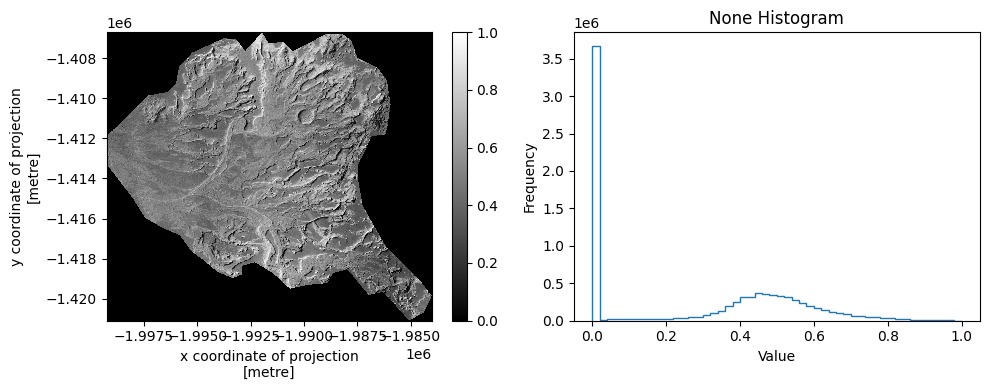

In [17]:
quick_plot(ctxIMG_clipped)

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: -1999243.385695122
Min Latitude: -1421081.4923999987
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4084999997

Image Bounding Box Coordinates:
Min Longitude: -1999244.7979242108
Min Latitude: -1421082.7482647875
Max Longitude: -1984004.875692997
Max Latitude: -1406717.821568502



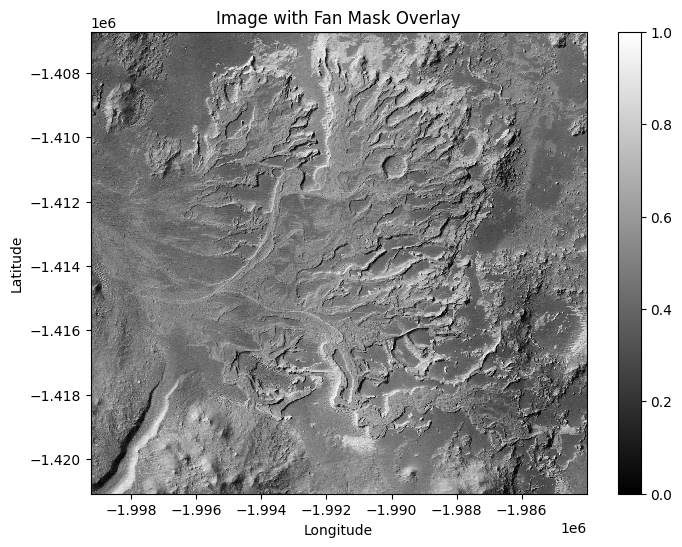

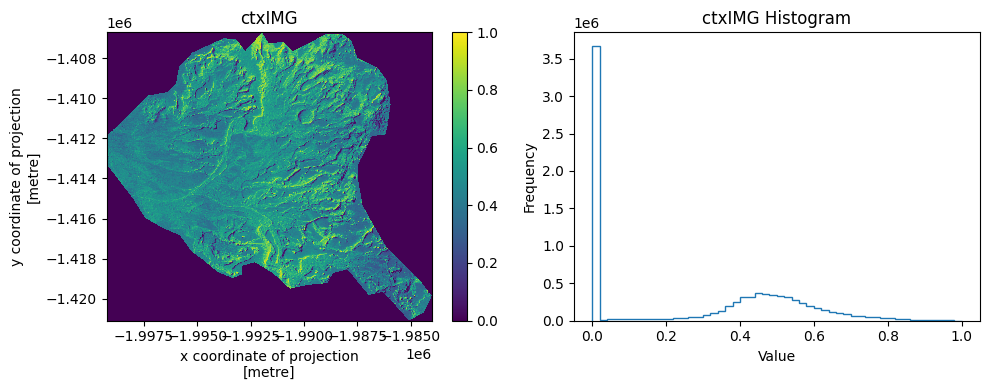

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: -5892.206441908466
Min Latitude: -1421081.4923999987
Max Longitude: 8040.296220736653
Max Latitude: -1406716.4084999997

Image Bounding Box Coordinates:
Min Longitude: -5895.0
Min Latitude: -1421073.0
Max Longitude: 8055.0
Max Latitude: -1406709.0



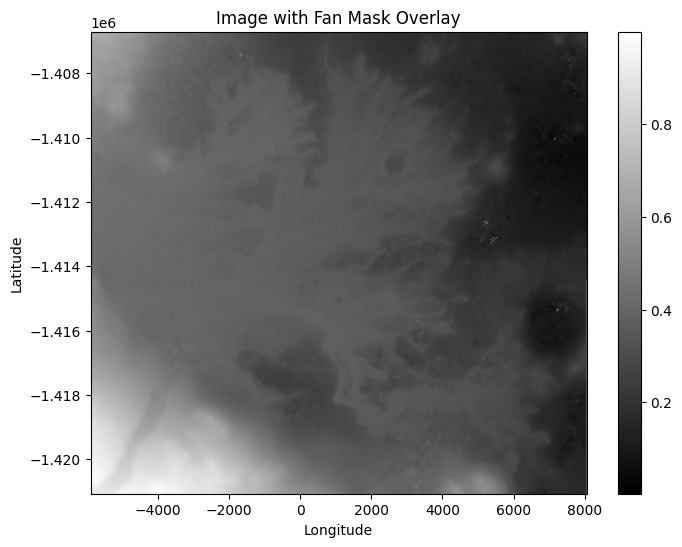

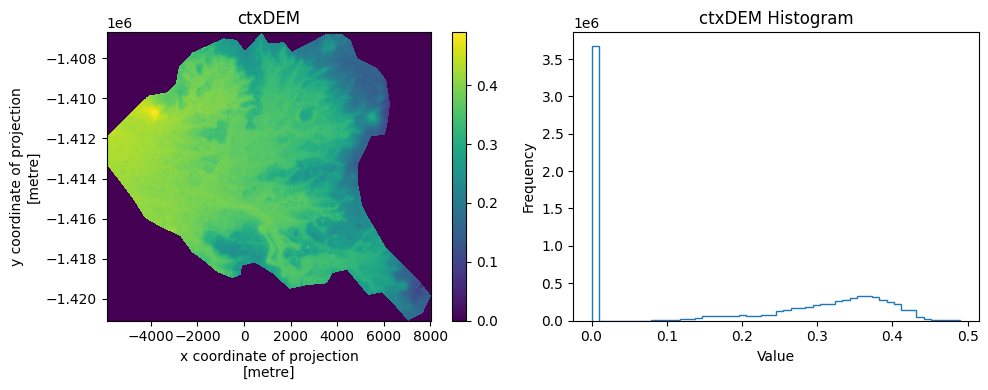

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: -5892.206441908466
Min Latitude: -1421081.4923999987
Max Longitude: 8040.296220736653
Max Latitude: -1406716.4084999997

Image Bounding Box Coordinates:
Min Longitude: -5895.0
Min Latitude: -1421073.0
Max Longitude: 8055.0
Max Latitude: -1406709.0



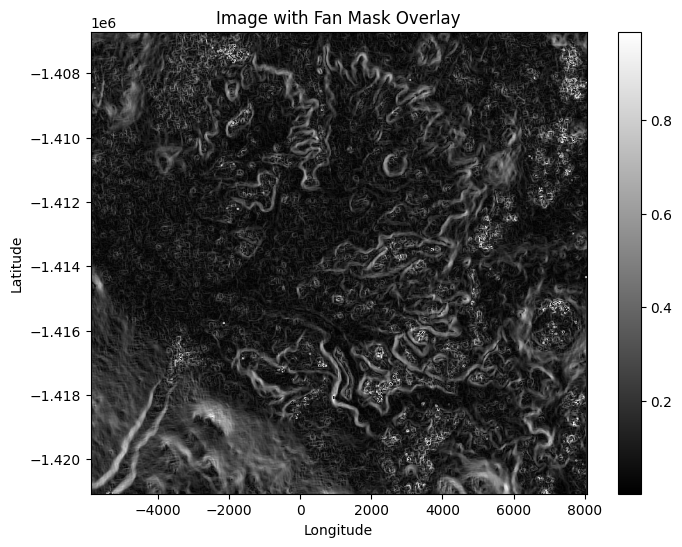

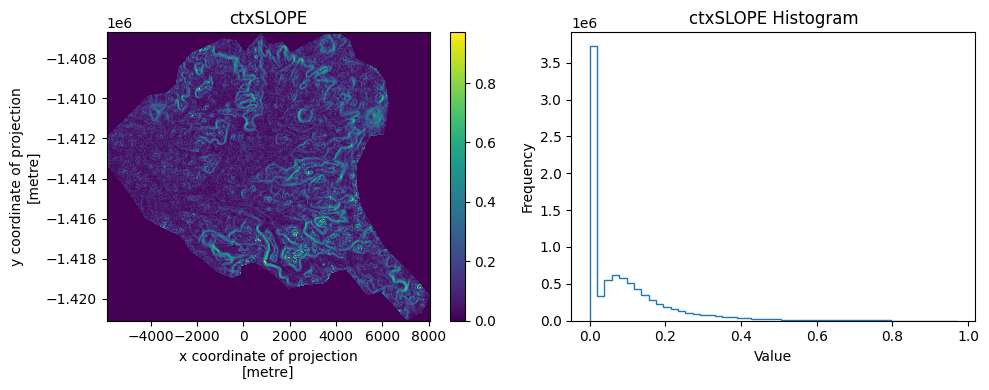

In [15]:
ctxIMG_clipped = clip_image(fan_mask, ctxIMG, gdf_eb, "ctxIMG")
ctxDEM_clipped = clip_image(fan_mask, ctxDEM, gdf_eb, "ctxDEM")
ctxSLOPE_clipped = clip_image(fan_mask, ctxSLOPE, gdf_eb, "ctxSLOPE")

# BLEND Imagery

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: -1999243.385695122
Min Latitude: -1421081.4923999987
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4084999997

Image Bounding Box Coordinates:
Min Longitude: -1999245.9164650324
Min Latitude: -1421076.9406225528
Max Longitude: -1984045.9171001394
Max Latitude: -1406676.9412242328



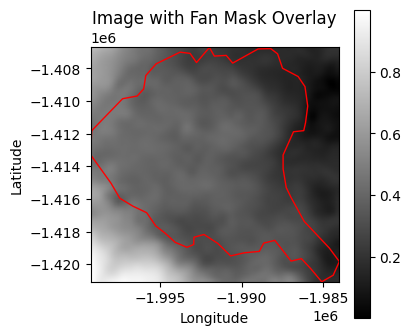

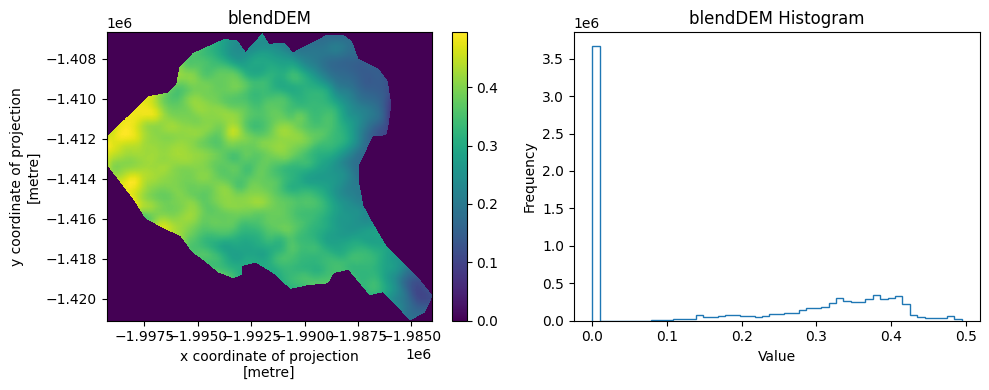

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: -1999243.385695122
Min Latitude: -1421081.4923999987
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4084999997

Image Bounding Box Coordinates:
Min Longitude: -1999245.9164650324
Min Latitude: -1421076.9406225528
Max Longitude: -1984045.9171001394
Max Latitude: -1406676.9412242328



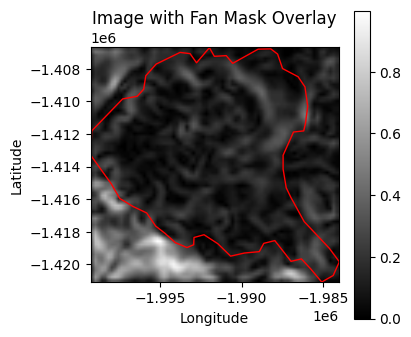

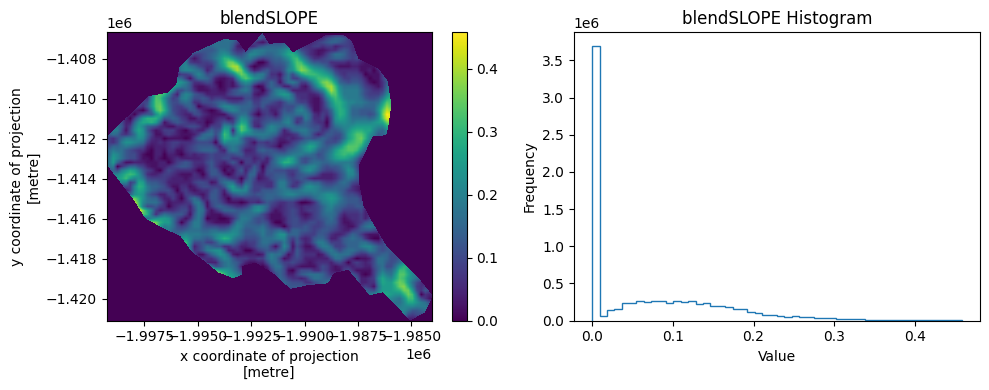

In [11]:
blendDEM_clipped = clip_image(fan_mask, blendDEM, gdf_eb, "blendDEM")
blendSLOPE_clipped = clip_image(fan_mask, blendSLOPE, gdf_eb, "blendSLOPE")

## IR Imagery

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: 8670202.168499999
Min Latitude: -1421081.4923999987
Max Longitude: 8685442.199000003
Max Latitude: -1406716.4084999997

Image Bounding Box Coordinates:
Min Longitude: 8670200.0
Min Latitude: -1421099.9999999998
Max Longitude: 8685400.0
Max Latitude: -1406700.0



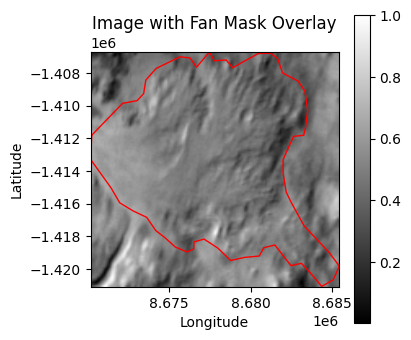

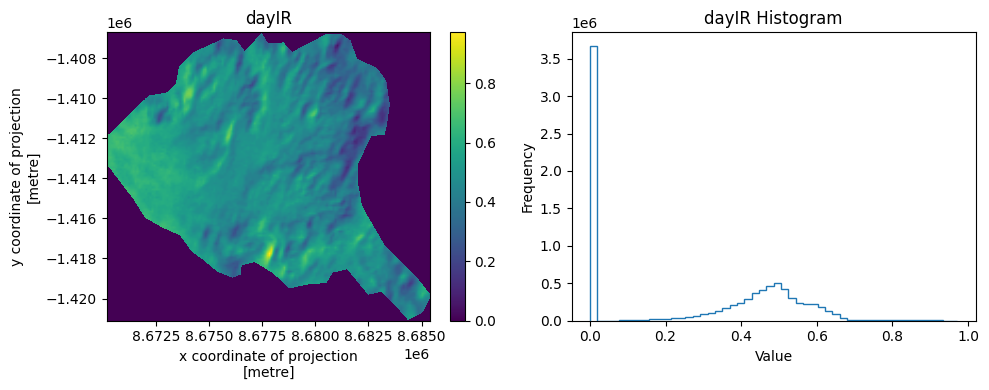

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: 8670202.168499999
Min Latitude: -1421081.4923999987
Max Longitude: 8685442.199000003
Max Latitude: -1406716.4084999997

Image Bounding Box Coordinates:
Min Longitude: 8670200.0
Min Latitude: -1421099.9999999998
Max Longitude: 8685400.0
Max Latitude: -1406700.0



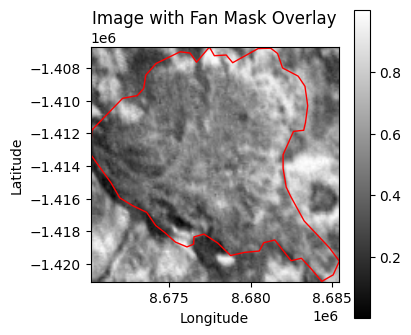

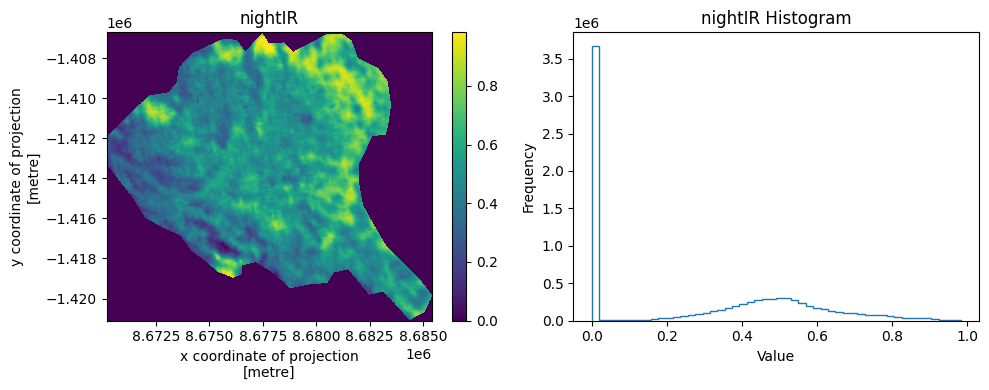

In [12]:
dayIR_clipped = clip_image(fan_mask, dayIR, gdf_eb, "dayIR")
nightIR_clipped = clip_image(fan_mask, nightIR, gdf_eb, "nightIR")

## HRSC Imagery

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: 14721.755786645204
Min Latitude: -1421001.9899329531
Max Longitude: 28635.910048826405
Max Latitude: -1406637.7096882092

Image Bounding Box Coordinates:
Min Longitude: 14706.25
Min Latitude: -1421006.2500000002
Max Longitude: 28681.25
Max Latitude: -1406643.7500000002



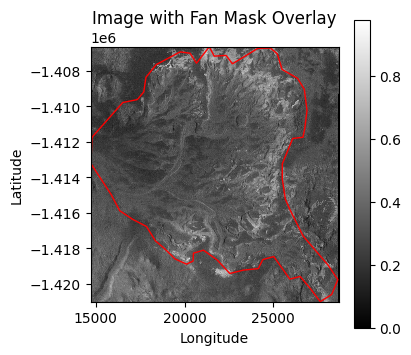

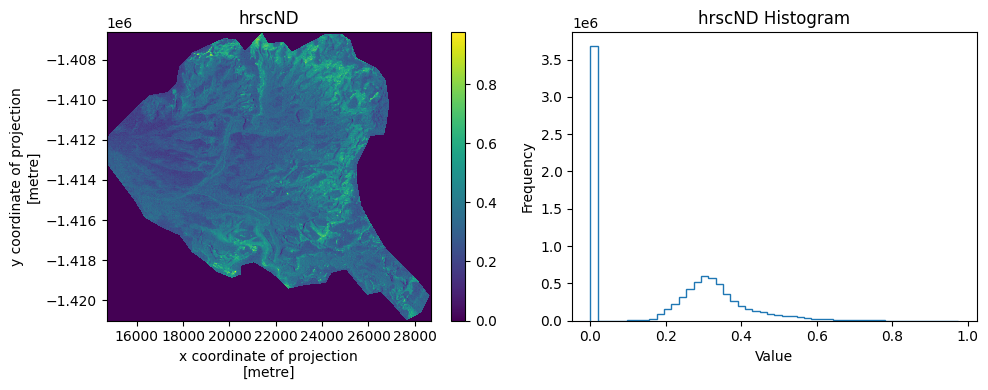

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: 14721.755786645204
Min Latitude: -1421001.9899329531
Max Longitude: 28635.910048826405
Max Latitude: -1406637.7096882092

Image Bounding Box Coordinates:
Min Longitude: 14706.25
Min Latitude: -1420993.7500000002
Max Longitude: 28681.25
Max Latitude: -1406643.7500000002



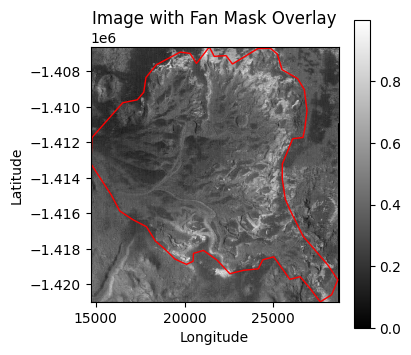

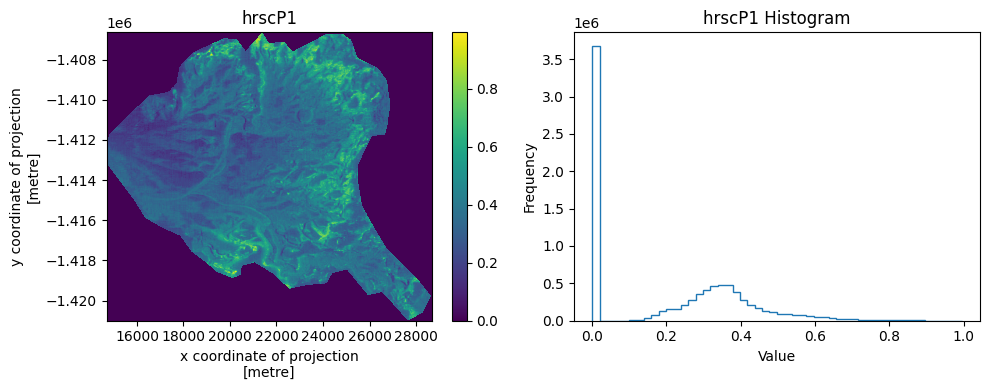

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: 14721.755786645204
Min Latitude: -1421001.9899329531
Max Longitude: 28635.910048826405
Max Latitude: -1406637.7096882092

Image Bounding Box Coordinates:
Min Longitude: 14706.25
Min Latitude: -1420993.7500000002
Max Longitude: 28681.25
Max Latitude: -1406643.7500000002



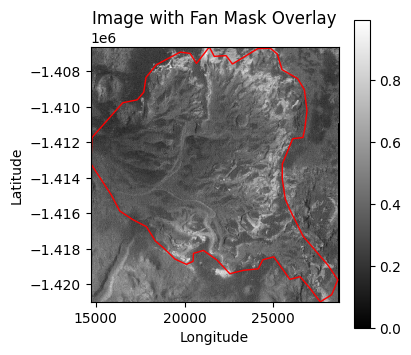

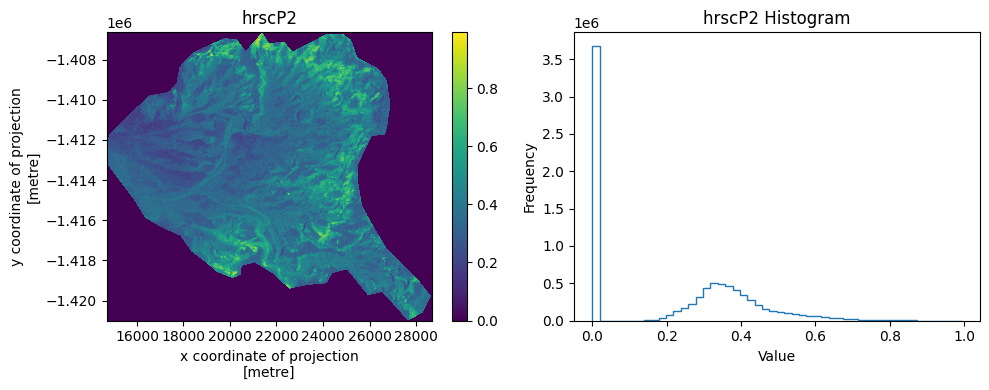

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: 14721.755786645204
Min Latitude: -1421001.9899329531
Max Longitude: 28635.910048826405
Max Latitude: -1406637.7096882092

Image Bounding Box Coordinates:
Min Longitude: 14706.25
Min Latitude: -1421006.2500000002
Max Longitude: 28681.25
Max Latitude: -1406643.7500000002



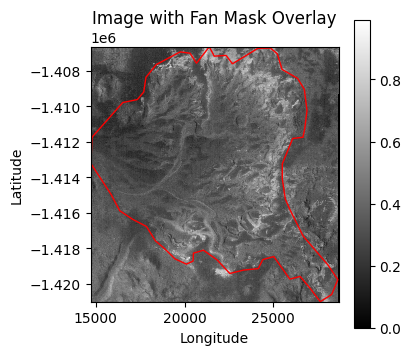

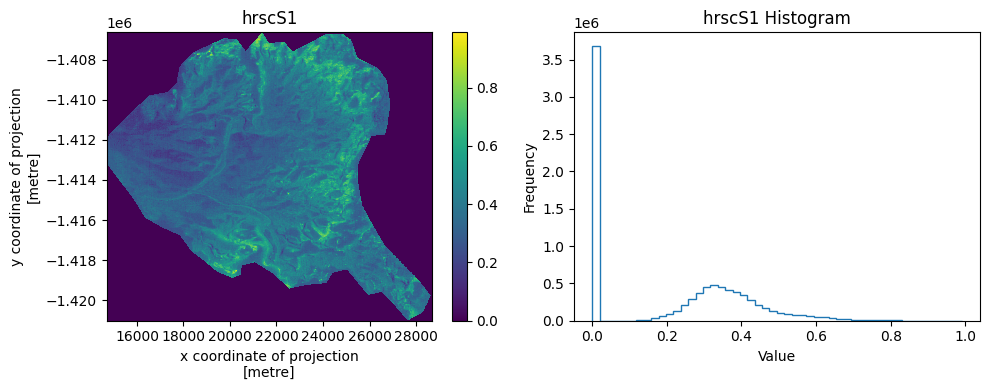

Old Mask Bounding Box Coordinates:
Min Longitude: -1999243.3856951222
Min Latitude: -1421081.492399999
Max Longitude: -1984003.3551951163
Max Latitude: -1406716.4085

New Mask Bounding Box Coordinates:
Min Longitude: 14721.755786645204
Min Latitude: -1421001.9899329531
Max Longitude: 28635.910048826405
Max Latitude: -1406637.7096882092

Image Bounding Box Coordinates:
Min Longitude: 14706.25
Min Latitude: -1421006.2500000002
Max Longitude: 28681.25
Max Latitude: -1406643.7500000002



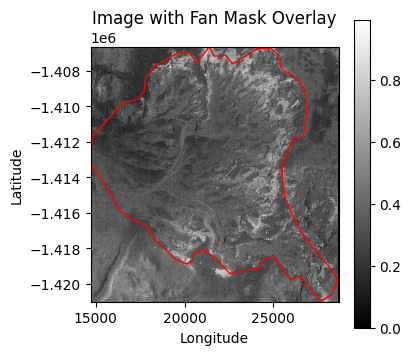

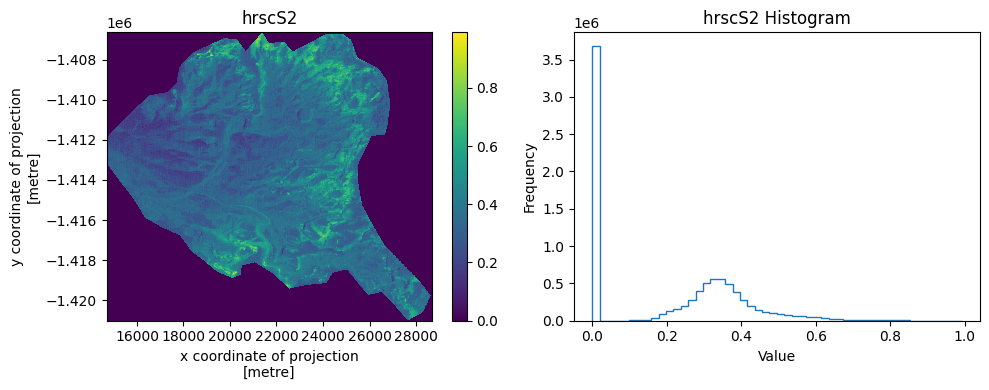

In [13]:
hrscND_clipped = clip_image(fan_mask, hrscND, gdf_eb, "hrscND")
hrscP1_clipped = clip_image(fan_mask, hrscP1, gdf_eb, "hrscP1")
hrscP2_clipped = clip_image(fan_mask, hrscP2, gdf_eb, "hrscP2")
hrscS1_clipped = clip_image(fan_mask, hrscS1, gdf_eb, "hrscS1")
hrscS2_clipped = clip_image(fan_mask, hrscS2, gdf_eb, "hrscS2")

In [14]:
save_path = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/ai_ready_masked/'

blendDEM_clipped.rio.to_raster(save_path + "blendDEM_aiready_masked.tif")
blendSLOPE_clipped.rio.to_raster(save_path + "blendSLOPE_aiready_masked.tif")
ctxDEM_clipped.rio.to_raster(save_path + "ctxDEM_aiready_masked.tif")
ctxIMG_clipped.rio.to_raster(save_path + "ctxIMG_aiready_masked.tif")
ctxSLOPE_clipped.rio.to_raster(save_path + "ctxSLOPE_aiready_masked.tif")
dayIR_clipped.rio.to_raster(save_path + "dayIR_aiready_masked.tif")
nightIR_clipped.rio.to_raster(save_path + "nightIR_aiready_masked.tif")
hrscND_clipped.rio.to_raster(save_path + "hrscND_aiready_masked.tif")
hrscP1_clipped.rio.to_raster(save_path + "hrscP1_aiready_masked.tif")
hrscP2_clipped.rio.to_raster(save_path + "hrscP2_aiready_masked.tif")
hrscS1_clipped.rio.to_raster(save_path + "hrscS1_aiready_masked.tif")
hrscS2_clipped.rio.to_raster(save_path + "hrscS2_aiready_masked.tif")